In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

import tensorflow as tf
from tensorflow import keras

from pylab import rcParams
from scipy import stats

In [4]:
column_names = ['user_id','activity','timestamp','x_axis','y_axis','z_axis']

df = pd.read_csv('WISDM_ar_v1.1_raw.txt',header=None,names = column_names)
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.69;
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.73;
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.69;
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.73;


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098204 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1098204 non-null  int64  
 1   activity   1098204 non-null  object 
 2   timestamp  1098204 non-null  int64  
 3   x_axis     1098204 non-null  float64
 4   y_axis     1098204 non-null  float64
 5   z_axis     1098203 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 50.3+ MB


In [6]:
df.z_axis.replace(regex = True,to_replace=r';',value = r'',inplace=True)

In [7]:
df['z_axis'] = df.z_axis.astype('float64')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098204 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1098204 non-null  int64  
 1   activity   1098204 non-null  object 
 2   timestamp  1098204 non-null  int64  
 3   x_axis     1098204 non-null  float64
 4   y_axis     1098204 non-null  float64
 5   z_axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 50.3+ MB


In [9]:
df.dropna(axis=0,how='any',inplace=True)

In [10]:
df.shape

(1098203, 6)

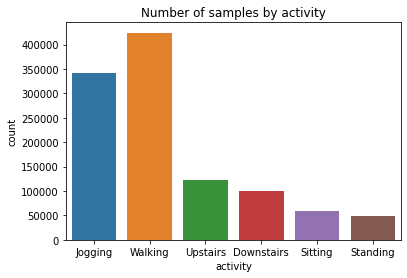

In [11]:
sns.countplot(x='activity',data=df)
plt.title("Number of samples by activity")
plt.show()

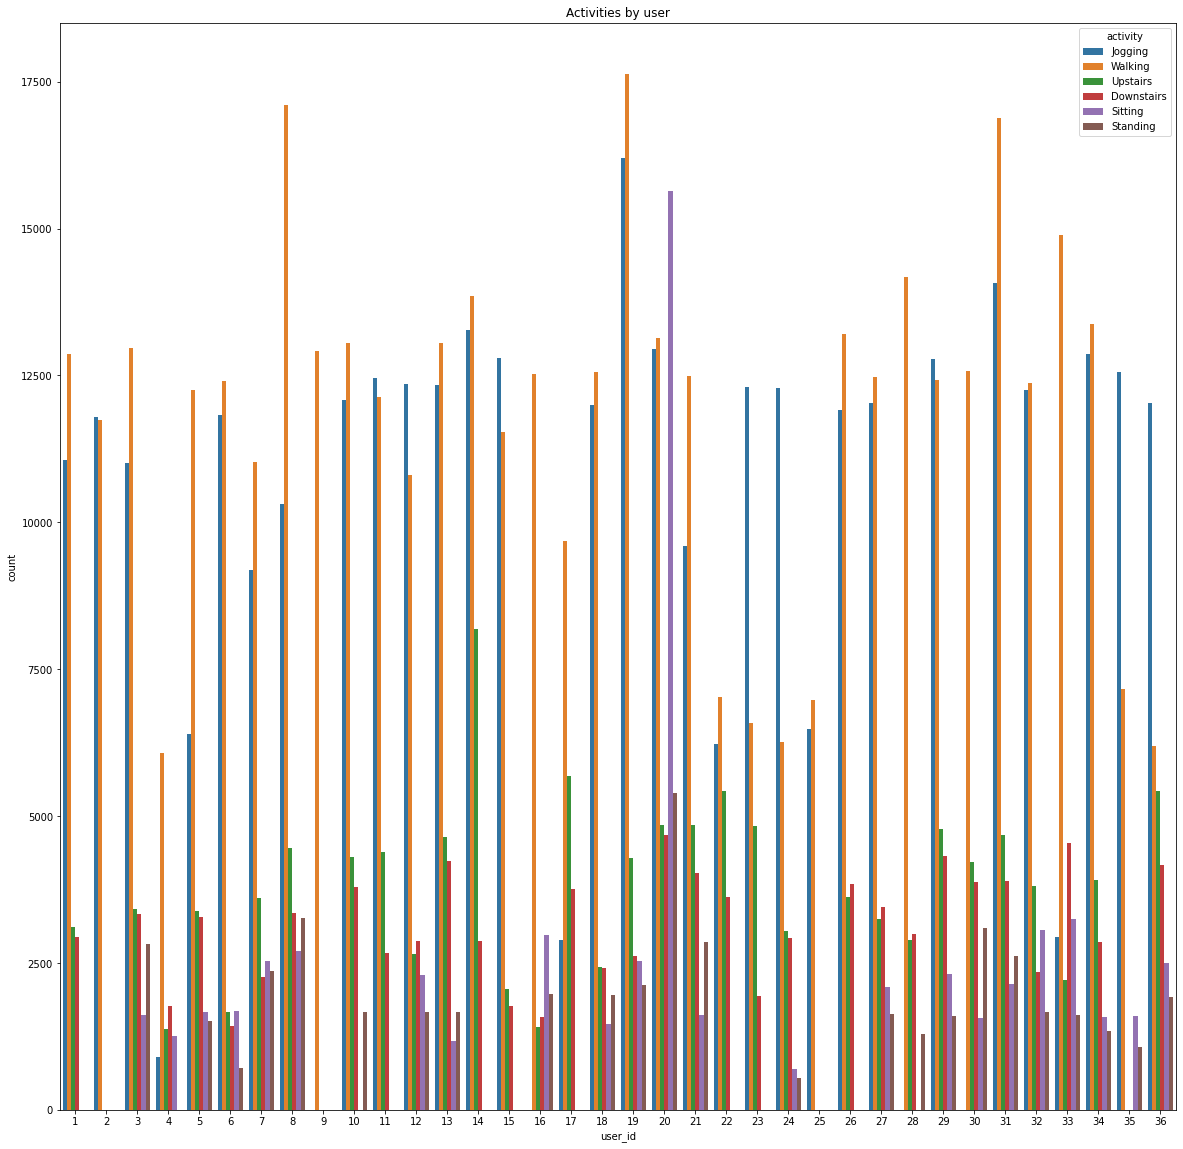

In [12]:
plt.figure(figsize=(20,20))
sns.countplot(x='user_id',hue='activity',data=df)
plt.title('Activities by user')
plt.show()

In [13]:
df_train = df[df['user_id']<=30]
df_test = df[df['user_id']>30]

In [14]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

In [15]:
scale_columns = ['x_axis','y_axis','z_axis']

scaler = RobustScaler()
scaler = scaler.fit(df_train[scale_columns])

In [16]:
df_train.loc[:, scale_columns] = scaler.transform(
  df_train[scale_columns].to_numpy()
)
df_test.loc[:, scale_columns] = scaler.transform(
  df_test[scale_columns].to_numpy()
)

In [17]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [18]:
TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']],
    df_train.activity,
    TIME_STEPS,
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']],
    df_test.activity,
    TIME_STEPS,
    STEP
)

In [19]:
X_train.shape,y_train.shape

((22454, 200, 3), (22454, 1))

In [20]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [21]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128,input_shape = (X_train.shape[1],X_train.shape[2])))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dense(y_train.shape[1],activation='softmax'))
model.compile(loss = 'categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 84,870
Trainable params: 84,870
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(X_train,y_train,epochs=25,batch_size=64)

Epoch 1/25
351/351 [==============================] - 11s 13ms/step - loss: 1.1167 - accuracy: 0.6389
Epoch 2/25
351/351 [==============================] - 5s 13ms/step - loss: 1.0505 - accuracy: 0.6503
Epoch 3/25
351/351 [==============================] - 5s 13ms/step - loss: 0.9338 - accuracy: 0.6861
Epoch 4/25
351/351 [==============================] - 5s 13ms/step - loss: 0.7406 - accuracy: 0.7533
Epoch 5/25
351/351 [==============================] - 5s 13ms/step - loss: 0.6410 - accuracy: 0.7832
Epoch 6/25
351/351 [==============================] - 4s 13ms/step - loss: 0.5438 - accuracy: 0.8121
Epoch 7/25
351/351 [==============================] - 5s 13ms/step - loss: 0.4747 - accuracy: 0.8308
Epoch 8/25
351/351 [==============================] - 4s 13ms/step - loss: 0.4624 - accuracy: 0.8360
Epoch 9/25
351/351 [==============================] - 4s 13ms/step - loss: 0.4818 - accuracy: 0.8260
Epoch 10/25
351/351 [==============================] - 5s 13ms/step - loss: 0.4300 - accur

In [24]:
model.evaluate(X_test,y_test,batch_size=64)

78/78 [==============================] - 1s 7ms/step - loss: 0.5610 - accuracy: 0.8047


[0.5610035061836243, 0.8046875]

In [25]:
y_pred = model.predict(X_test)

In [26]:
from sklearn.metrics import confusion_matrix,accuracy_score

In [30]:
y_test = [np.argmax(i) for i in y_test]
y_pred = [np.argmax(i) for i in y_pred]

In [33]:
accuracy_score(y_test,y_pred)

0.8046875

In [36]:
def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim()
  b += 0.5 
  t -= 0.5
  plt.ylim(b, t) 
  plt.show() 

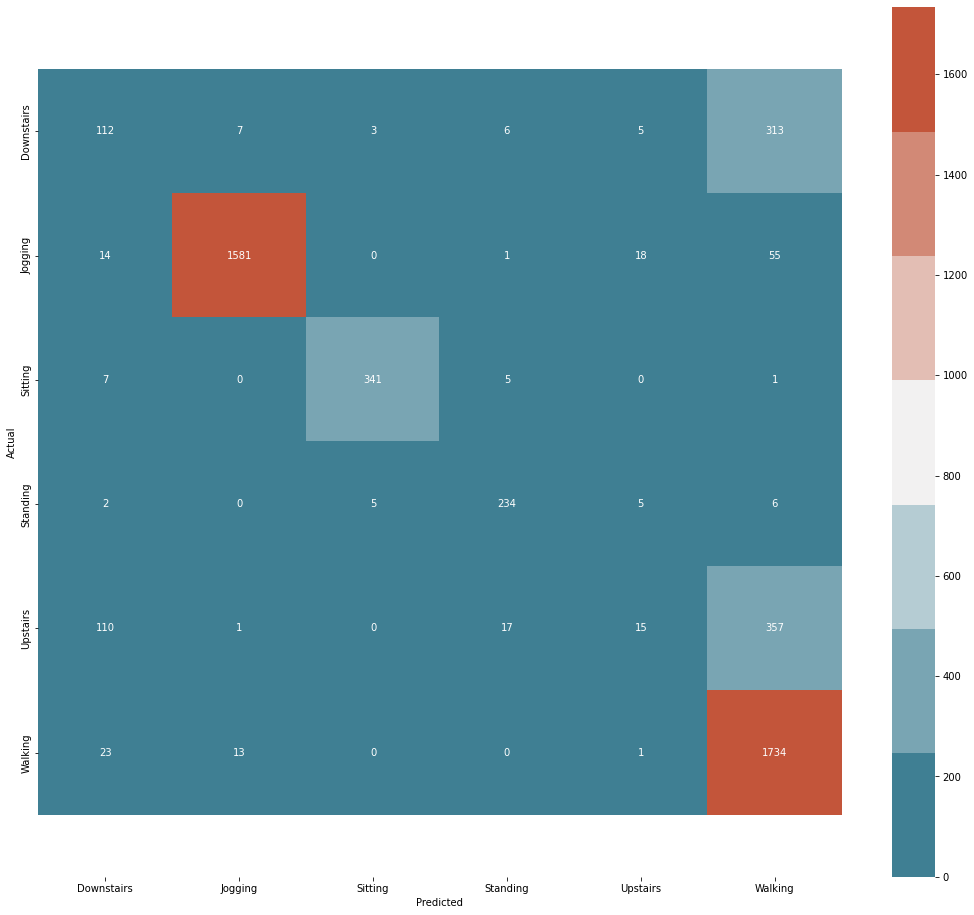

In [38]:
plot_cm(
  y_test,
  y_pred,
  enc.categories_[0]
)